In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.integrate import solve_ivp

In [2]:
#Sensitivity function - rs are resource concs, specInd is the index of the species under consideration, Kms are the half-maximal velocity concentrations and fs are the investment fractions/leakage penalties
def sensFunc(rs,v,D,Ks,Kl,specInd):
    monodL = (rs[0])/(rs[0]+Kl[specInd])
    monodS = (rs[1])/(rs[1]+Ks[specInd])
    
    sens = v[specInd] * min(monodL,monodS) - D
    
    return sens

#Gradient of the sensitivity function in the resource space
def gradSensFunc(rs,v,D,Ks,Kl,specInd):
    sensGrad = np.zeros(rs.shape)

    monodL = (rs[0])/(rs[0]+Kl[specInd])
    monodS = (rs[1])/(rs[1]+Ks[specInd])
    
    if monodL > monodS: #If soil is limiting
        sensGrad[0] = 0
        sensGrad[1] = v[specInd] * Ks[specInd]/(rs[1] + Ks[specInd])**2
    else: #If light is limiting
        sensGrad[0] = v[specInd] * Kl[specInd]/(rs[0] + Kl[specInd])**2
        sensGrad[1] = 0
    
    return sensGrad

#Impact function for a single species
def impactFunc(rs,v,D,Ks,Kl,c,Yc,Yo,Lmax,specInd):
    impact = np.zeros(rs.shape)
    
    monodL = (rs[0])/(rs[0]+Kl[specInd])
    monodS = (rs[1])/(rs[1]+Ks[specInd])
    
    impact[0] = -c[specInd] * rs[0]/Lmax * (v[specInd] * min(monodL,monodS) - D) #Light impact
    impact[1] = -Yc[specInd] * v[specInd] * min(monodL,monodS) + Yo[specInd]*D #Soil impact
    
    return impact

In [3]:
#Define function used to generate the values of dY at each timepoint
def batchReact(t, y, v, D, Ks, Kl, c, Yc, Yo, Lmax):    
    
    #We have three separate populations: The nutrient N, the toxin T and the bacteria X
    r = y[0:2] #Resource vector
    s = y[2:] #plants
    
    dr = np.zeros(r.shape)
    ds = np.zeros(s.shape)
    
    for i in np.arange(s.shape[0]):
        sens = sensFunc(r,v,D,Ks,Kl,i)
        impact = impactFunc(r,v,D,Ks,Kl,c,Yc,Yo,Lmax,i)
    
        dr = dr + impact*s[i]
        ds[i] = sens*s[i]
    
    dY = np.concatenate((dr,ds),axis=0)
    return dY

In [4]:
#4-species model
v = (0.1,0.1,0.1,0.1) #Maximal population growth rates
D = 0.03 #Death rate
Ks = (0.1,0.4,1.25,5) #Half-maximal soil quality growth constants
Kl = (5,1.25,0.4,0.1) #Half-maximal light quality growth consta5nts
c = (0.1,0.2,0.3,0.4) #Fractional remaining light uptake per plant
Yc = (1,1,1,1) #Soil quality decrease needed for one unit of plant to grow
Yo = (1.45,1.3,1.15,1) #Soil quality improvement from death of one unit of plant
Lmax = 3 #Maximum amount of light available

#3-species model
#v = (0.1,0.1,0.1) #Maximal population growth rates
#D = 0.03 #Death rate
#Ks = (0.1,0.35,1.225) #Half-maximal soil quality growth constants
#Kl = (1.225,0.35,0.1) #Half-maximal light quality growth consta5nts
#c = (0.2,0.4,0.6) #Fractional remaining light uptake per plant
#Yc = (1,1,1) #Soil quality decrease needed for one unit of plant to grow
#Yo = (1.5,1,1) #Soil quality improvement from death of one unit of plant
#Lmax = 1

minL = 0
maxL = 5
minS = 0
maxS = 20

sampPtsL = 200
sampPtsS = 200

lList = np.linspace(minL,maxL,sampPtsL)
sList = np.linspace(minS,maxS,sampPtsS)

lField, sField = np.meshgrid(lList, sList)

lStep = lField[1,0] - lField[0,0]
sStep = sField[0,1] - sField[0,0]

impacts = np.zeros((sampPtsL,sampPtsS,2)) 
sensitivities = np.zeros((sampPtsL,sampPtsS))
sensGrads = np.zeros((sampPtsL,sampPtsS,2))
sp1on1 = np.zeros((sampPtsL,sampPtsS))

for lInd in range(sampPtsL):
    for sInd in range(sampPtsS):
        r = np.array([lField[lInd,sInd],sField[lInd,sInd]])
        
        impacts[lInd,sInd] = impactFunc(r,v,D,Ks,Kl,c,Yc,Yo,Lmax,1)
        sensitivities[lInd,sInd] = sensFunc(r,v,D,Ks,Kl,0)
        sensGrads[lInd,sInd,:] = gradSensFunc(r,v,D,Ks,Kl,0)
        
        sp1on1[lInd,sInd] = np.dot(impacts[lInd,sInd],sensGrads[lInd,sInd])

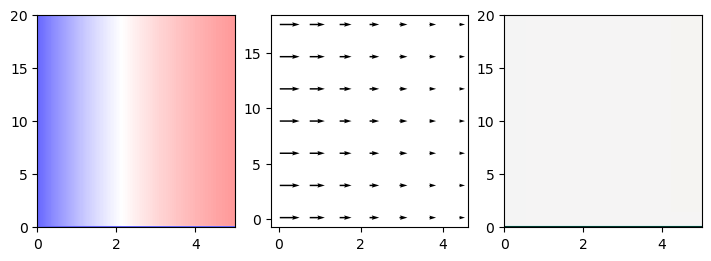

In [5]:
#Plot sensitivity and impact functions
fig, axAr = plt.subplots(nrows = 1, ncols = 3, constrained_layout = True, figsize=(7,2.5))
ax1=axAr[0]
ax2=axAr[1]
ax3=axAr[2]

ptDensity = 7 #How large the spacing between points in the quiver lattice should be

subL = lField[1:sampPtsL:round(sampPtsL/ptDensity),1:sampPtsS:round(sampPtsS/ptDensity)]
subS = sField[1:sampPtsL:round(sampPtsL/ptDensity),1:sampPtsS:round(sampPtsS/ptDensity)]
subSensGradL = sensGrads[1:sampPtsL:round(sampPtsL/ptDensity),1:sampPtsS:round(sampPtsS/ptDensity),0]
subSensGradS = sensGrads[1:sampPtsL:round(sampPtsL/ptDensity),1:sampPtsS:round(sampPtsS/ptDensity),1]
subImpactsL = impacts[1:sampPtsL:round(sampPtsL/ptDensity),1:sampPtsS:round(sampPtsS/ptDensity),0]
subImpactsS = impacts[1:sampPtsL:round(sampPtsL/ptDensity),1:sampPtsS:round(sampPtsS/ptDensity),1]

ax1.imshow(sensitivities,aspect='auto',extent=[minL,maxL,minS,maxS], origin='lower', cmap='bwr',vmin = -0.05, vmax=0.05)
ax2.quiver(subL,subS,subSensGradL,subSensGradS,color='black')
ax3.imshow(sp1on1,cmap='BrBG',aspect='auto',vmin = -0.01, vmax = 0.01,extent=[minL,maxL,minS,maxS], origin='lower')

In [6]:
inArgs = (v, D, Ks, Kl, c, Yc, Yo, Lmax)

#Time settings for the solver
tSpan = [0,2500]
dt = 1
tSteps = np.arange(tSpan[0],tSpan[1],dt)

initConds = [Lmax,0.02,0.005,0.005,0.005,0.005] #Light,soil,species

batchSol = solve_ivp(fun=batchReact, t_span=tSpan, y0=initConds, t_eval=tSteps, args=inArgs)

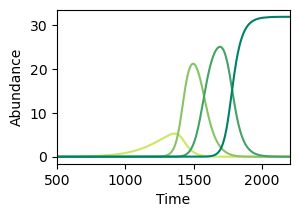

In [10]:
#Get appropriate colormap
x = np.linspace(0.8, 0, 4)
rgb = mpl.colormaps['summer'](x)[np.newaxis, :, :3]

plt.figure(figsize=[3,2])

for i in range(len(v)):
    plt.plot(batchSol.y[2+i,:],color=rgb[:,i])
plt.xlabel('Time')
plt.ylabel('Abundance')
plt.xlim([500,2200])

plt.savefig('C:\\Users\\omeacock\\OneDrive - Université de Lausanne\\Writing\\Interactions\\Figures\\PDFs\\Succession\\Populations.pdf')

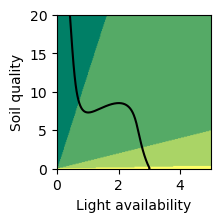

In [11]:
plt.figure(figsize=(2.5,2))

maxGrow = np.zeros((sampPtsL,sampPtsS)) 

for lInd in range(sampPtsL):
    for sInd in range(sampPtsS):
        r = np.array([lField[lInd,sInd],sField[lInd,sInd]])

        GRs = np.array([sensFunc(r,v,D,Ks,Kl,s) for s in range(len(v))])
        maxGrow[lInd,sInd] = np.argmax(GRs)

plt.imshow(0.8-maxGrow*0.8,extent=[minL,maxL,minS,maxS], origin='lower', cmap='summer')

plt.plot(batchSol.y[0,:],batchSol.y[1,:],'k')
plt.xlim([minL,maxL])
plt.ylim([minS,maxS])
plt.gca().set_aspect(1/4)
plt.gca().set_xlabel('Light availability')
plt.gca().set_ylabel('Soil quality')

plt.savefig('C:\\Users\\omeacock\\OneDrive - Université de Lausanne\\Writing\\Interactions\\Figures\\PDFs\\Succession\\EnviroTrajectory.pdf')

C:\Users\omeacock\Anaconda3\lib\site-packages\matplotlib\lines.py:1205: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val
C:\Users\omeacock\Anaconda3\lib\site-packages\matplotlib\lines.py:1205: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val
C:\Users\omeacock\Anaconda3\lib\site-packages\matplotlib\lines.py:1205: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val
C:\Users\omeacock\Anaconda3\lib\site-packages\matplotlib\lines.py:1205: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val


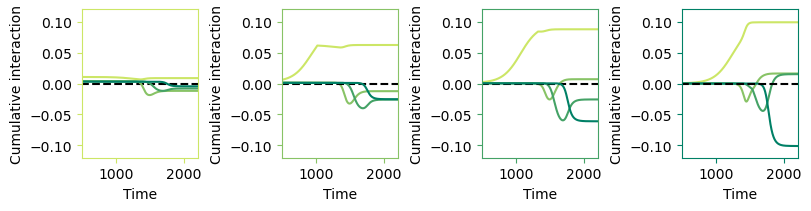

In [12]:
fig, axAr = plt.subplots(nrows = 1, ncols = len(v), constrained_layout = True, figsize=(8,2))

solL = batchSol.y[0,:]
solS = batchSol.y[1,:]
solX = batchSol.y[2:,:]

for beta in range(len(v)): #Impactor (beta)
    for alph in range(len(v)): #Impactee (alpha)
        interactRateOverTime = np.zeros(solL.shape)
        for i in range(len(solL)):
            r = np.array([solL[i],solS[i]])
            interactRateOverTime[i] = np.dot(impactFunc(r,v,D,Ks,Kl,c,Yc,Yo,Lmax,beta),gradSensFunc(r,v,D,Ks,Kl,alph))

        interactOverTime = np.cumsum(np.multiply(interactRateOverTime,solX[beta,:]))*dt

        #axAr[alph].plot(np.multiply(interactRateOverTime,solX[beta,:]),color=rgb[:,beta])
        axAr[alph].plot(interactOverTime,color=rgb[:,beta])
        
    #axAr[s1].plot(np.divide(np.diff(solX[s1,:]),solX[s1,0:-1]),'k')
    axAr[beta].set_ylim([-0.12,0.12])
    axAr[beta].plot(tSpan,[0,0],'k--')
    axAr[beta].set_xlabel('Time')
    axAr[beta].set_ylabel('Cumulative interaction')
    axAr[beta].set_xlim([500,2200])

    axAr[beta].tick_params(color=rgb[:,beta])
    for spine in axAr[beta].spines.values():
        spine.set_edgecolor(rgb[:,beta])
        plt.savefig('C:\\Users\\omeacock\\OneDrive - Université de Lausanne\\Writing\\Interactions\\Figures\\PDFs\\Succession\\CumInteracts.pdf')